<img src="img/banner.png" width = 90%>


## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

Projet de mise en place d'un système de classification binaire permettant de détecter des cas de pneumonie à partir de radios thoraciques, via utilisation d'un *modèle de vision par ordinateur préentraîné* type *CNN*. Utilisation du dataset *Chest X-Ray Pneumonia*.

Appréhension d'une démarche de suivi des expérimentations par *MLflow*, afin de tracer les paramètres d’entraînement, les métriques de performance et les versions de modèle.

**Contexte du projet** : Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.

_______________________________________________________________________________________________________________________________________________________

### Import des bibliothèques

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121   # DenseNet121 = modèle choisi, très utilisé dans le médical pour la détection
                                                        # de maladies pulmonaires
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import mlflow
import random

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

# 1. Exploration des données

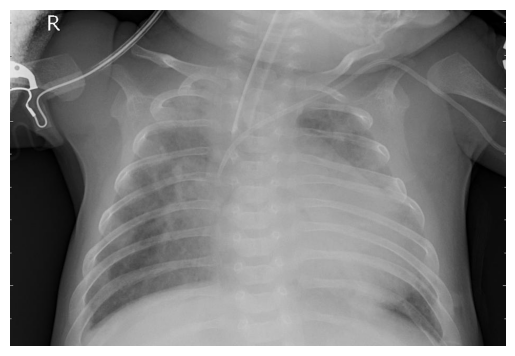

Shape (dimensions) : (640, 944, 3)
Type des valeurs : uint8


In [2]:
img = cv2.imread("data/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_COLOR_RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Shape (dimensions) : {img.shape}")
print(f"Type des valeurs : {img.dtype}")

En testant l'affichage de plusieurs images et leurs dimensions, nous pouvons voir que les radios sont de formats différents.

_______________________________________________________________________________________________________________________________________________________

# 2. Préparation des données

Fonction permettant de redimensionner nos images au format *224 x 224*, tout en gardant leur ratio d'origine avec un padding noir afin d'éviter les déformations.

In [3]:
def resize_with_padding(img, target_size = (224, 224, 3)):
        h, w = img.shape[:2]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(img, (new_w, new_h))

        padded = np.zeros(target_size, dtype=np.uint8)

        y_offset = (target_size[0] - new_h) // 2
        x_offset = (target_size[1] - new_w) // 2

        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return padded

Fonction parcourant nos dossiers afin de charger les photos. Chaque sous-dossier représente une classe (radio de poumons sains, ou atteints de pneumonie). Les datas sont initialement séparées en trois dossiers train, test, et val pour faciliter le travail.

In [4]:
def get_train_test(base_path: str):
    X = [] # images
    y = [] # labels
    label_to_int = {"NORMAL" : 0, "PNEUMONIA" : 1}

    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is None:
                print("Image illisible : ", file_path)
                continue
            img = resize_with_padding(img)
            X.append(img)
            y.append(label_to_int[label])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [5]:
X_train, y_train = get_train_test("data/train")
X_test, y_test = get_train_test("data/test")

Visualisation des 10 premières radios pour vérifier le fonctionement du traitement précédent.

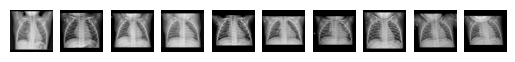

In [6]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

plt.show()

_______________________________________________________________________________________________________________________________________________________

# 3. Preprocessing

Ici nous convertissons le format *int* des pixels de nos images en format *float32*, pour ensuite normaliser nos données (division par 255)

In [7]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

display(X_train.shape)
display(X_test.shape)

(5216, 224, 224, 3)

(624, 224, 224, 3)

_______________________________________________________________________________________________________________________________________________________

# 4. Modélisation

### a. Importation du modèle **DenseNet121**, paramétrage, et compilation

Nous créons le modèle sur la base du modèle pré-entraîné **DenseNet121**. Ce dernier est très utilisé dans le domaine médical, notamment dans la détection de maladie pulmonaires. 

Nous l'importons avec ses *poids pré-entraînés* (sur *ImageNet*), c'est pourquoi nous avons dû précédemment normaliser nos données avec une certaine moyenne et un certain écart-type, les mêmes que lors de l'entraînement initial du modèle. 

Nous n'utilisons pas sa dernière couche (*include-top = False*) afin d'ajouter les couches (*model_outputs*) qui nous intéresse pour le résultat que nous recherchons.

In [8]:
# choix des paramètres de compilation

optimizer = 'adam'
loss_function = 'binary_crossentropy'

In [9]:

input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Importation du modèle DenseNet121 avec les poids pré-entraîné d'ImageNet, et en excluant la dernière couche (include-top=False)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)

# Gel des couches du modèle pré-entraîné
base_model.trainable = False

# Création des couches hautes
model_outputs = base_model.output
model_outputs = GlobalAveragePooling2D()(model_outputs)
model_outputs = Dense(1, activation='sigmoid')(model_outputs)

# Création du modèle
model = Model(inputs=inputs, outputs = model_outputs)

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

Nous pouvons voir toutes les couches de notre modèle. Initialement, il ne prend pas en compte les paramètres des couches gelées.

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

_______________________________________________________________________________________________________________________________________________________

# 5. Entraînement du modèle avec gel des couches basses

On définit un arrêt automatique pour éviter le surapprentissage, et réduire le temps d'entraînement inutile. Il servira également lors de l'entraînement suivant (avec plus de couches activées).

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)   # Surveillance pour empêcher le surapprentissage

nb_epochs = 10
batch_size = 32

### a. Entraînement

In [12]:
history_freeze = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=nb_epochs,
    batch_size = batch_size,
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8296 - loss: 0.3958 - val_accuracy: 0.7548 - val_loss: 0.4836
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9472 - loss: 0.1586 - val_accuracy: 0.8013 - val_loss: 0.4090
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9560 - loss: 0.1278 - val_accuracy: 0.7853 - val_loss: 0.4844
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9584 - loss: 0.1192 - val_accuracy: 0.7901 - val_loss: 0.4957
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9663 - loss: 0.1002 - val_accuracy: 0.7756 - val_loss: 0.5693


### b. Evaluation de la précision

In [13]:
loss_freeze, accuracy_freeze = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy_freeze*100:.2f}%")
print(f"Pertes : {loss_freeze}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6347 - loss: 0.6957
Précision : 80.13%
Pertes : 0.409038782119751


_______________________________________________________________________________________________________________________________________________________

# 6. Entraînement du modèle avec ajout des 15 dernières couches

Après avoir entraîné les dernières couches du modèle (que nous avons ajouté spécifiquement pour notre projet = outputs), nous dégelons les 15 dernières couches afin d'essayer d'optimiser au mieux les performances du modèle.

(Ici, difficilement possible d'ajouter plus de 15 couches pour l'optimisation, en raison d'un manque de performances de l'ordinateur.)

### a. Modélisation

In [14]:
for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. Résumé du modèle

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 329,153 (1.26 MB)

 Non-trainable params: 6,709,376 (25.59 MB)

### b. Entraînement

In [16]:
history_nofreeze = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=nb_epochs,
    batch_size = batch_size,
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9624 - loss: 0.1024 - val_accuracy: 0.8990 - val_loss: 0.2984
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9820 - loss: 0.0484 - val_accuracy: 0.6779 - val_loss: 1.9014
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.9872 - loss: 0.0349 - val_accuracy: 0.8237 - val_loss: 0.6831
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.9905 - loss: 0.0269 - val_accuracy: 0.7853 - val_loss: 1.2296


### c. Evaluation de la précision

In [17]:
loss_nofreeze, accuracy_nofreeze = model.evaluate(X_test, y_test)
print(f"Précision : {accuracy_nofreeze*100:.2f}%")
print(f"Pertes : {loss_nofreeze}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9122 - loss: 0.2670
Précision : 89.90%
Pertes : 0.2984309196472168


### d. Matrice de confusion

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


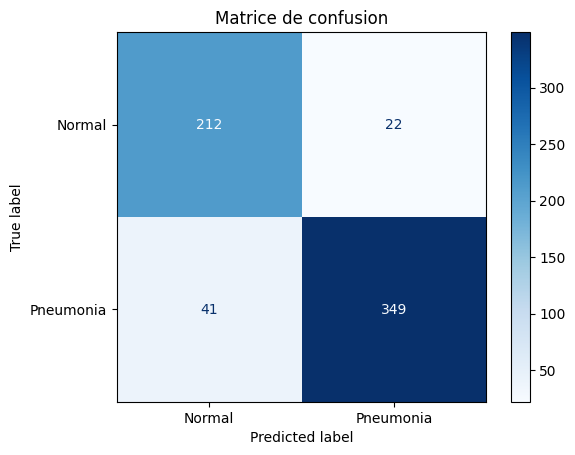

In [18]:
y_pred_proba = model.predict(X_test)

y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


La matrice de confusion nous démontre de bons résultats pour le modèle.

### e. Courbe de vérification de l'overfitting

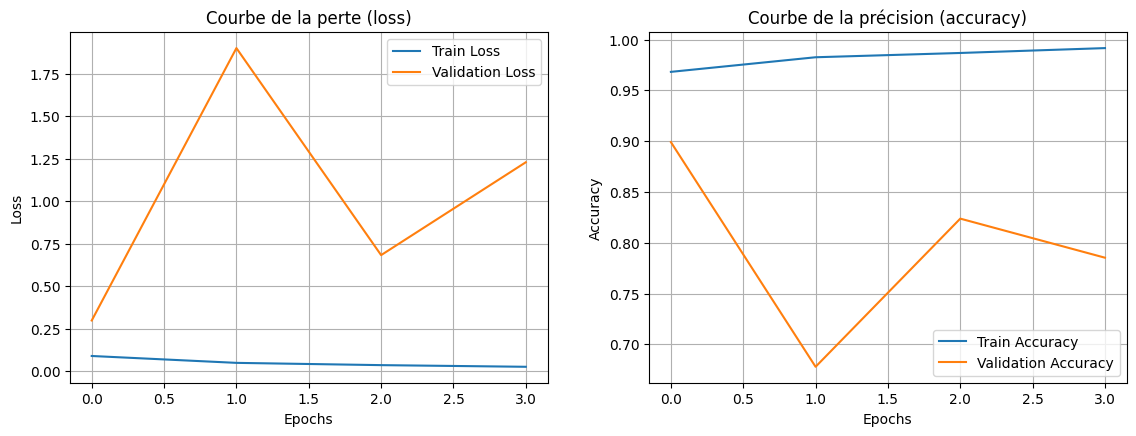

In [ ]:
plt.figure(figsize=(12, 5))

# Courbe de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history_nofreeze.history['loss'], label='Train Loss')
plt.plot(history_nofreeze.history['val_loss'], label='Validation Loss')
plt.title('Courbe de la perte (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_nofreeze.history['accuracy'], label='Train Accuracy')
plt.plot(history_nofreeze.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de la précision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(pad=3.0)

plt.show()

Ici, les courbes ne semblent pas très pertinentes. C'est dû au fait qu'avec notre entraînement, l'arrêt automatique par le *EarlyStop* est déclenché au bout de 4 epochs. Nous pouvons supposer qu'avec un entraînement sur un plus grand nombre de couches dégelées, il y aurait peut-être un plus grand nombre d'epochs parcouru, et donc des courbes plus précises.

_______________________________________________________________________________________________________________________________________________________

# 7. Prédiction

Test de l'efficacité de notre modèle par prédiction. Une image est sélectionnée aléatoirement à chaque exécution.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.587712421417236].


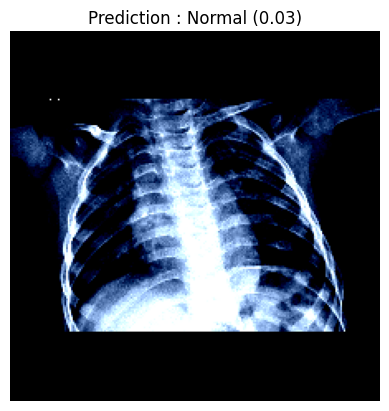

In [52]:
# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choix aléatoire d'une image dans X_test
img_to_predict = random.randint(0, len(X_test) - 1)

# Obtenir la prédiction (proba)
proba = model.predict(X_test[[img_to_predict]])[0][0]

# Classer selon le seuil 0.5
predicted_class = int(proba > 0.5)

# Afficher l’image avec prédiction
plt.imshow(X_test[img_to_predict])
plt.title(f"Prediction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()

_______________________________________________________________________________________________________________________________________________________

# 8. Mise en place du MLFlow

Ici nous centralisons dans un dictionnaire les paramètres qui nous intéresse pour le suivi des expériences.

In [49]:
# Centralisation des paramètres du modèle

params = {
    "model": "DenseNet121",
    "input_shape": input_shape,
    "batch_size": batch_size,
    "epochs": nb_epochs,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "early_stop_patience": early_stop.patience,
    "early_stop_monitor": early_stop.monitor,
    "early_stop_resto_best_weights": early_stop.restore_best_weights,
    "Two_phase_training": True
}

Nous suivons l'expérience sous le nom **Pneumonia detection**\
Nous enregistrons les *paramètres* utilisé en parcourant le dictionnaire dédié, ainsi que l'évaluation des résultats en *précision* et en *perte* (comparatif avant et après le dégel des dernières couches du modèle).\
Nous générons aussi des graphiques de suivi des *métriques de performance*, retrouvables dans l'onglet Artifacts de MLFlow.

In [ ]:
mlflow.set_experiment("Pneumonia detection")
mlflow.set_tracking_uri('http://127.0.0.1:5000')

with mlflow.start_run(run_name="Pneumonia detection - DenseNet121"):
    
    for name, value in params.items():
        mlflow.log_param(name, str(value))

    mlflow.log_metric("val_loss_freeze", loss_freeze)
    mlflow.log_metric("val_accuracy_freeze", accuracy_freeze)
    mlflow.log_metric("val_loss_nofreeze", loss_nofreeze)
    mlflow.log_metric("val_accuracy_nofreeze", accuracy_nofreeze)

    def plot_and_log(history, name):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].plot(history.history['accuracy'], label='train acc')
        ax[0].plot(history.history['val_accuracy'], label='val acc')
        ax[0].set_title(f"{name} Accuracy")
        ax[0].legend()

        ax[1].plot(history.history['loss'], label='train loss')
        ax[1].plot(history.history['val_loss'], label='val loss')
        ax[1].set_title(f"{name} Loss")
        ax[1].legend()

        file_path = f"{name.replace(' ', '_')}_metrics.png"
        mlflow.log_figure(fig, file_path)
        plt.close()

    # 3.1 Tracer et logger les graphes
    plot_and_log(history_freeze, "Phase 1 - Frozen")
    plot_and_log(history_nofreeze, "Phase 2 - Unfrozen")

    # ==============================
    # 4. Logger le modèle final
    # ==============================
    mlflow.keras.log_model(model, "final_model")


2025/05/23 15:42:35 INFO mlflow.tracking.fluent: Experiment with name 'Pneumonia detection' does not exist. Creating a new experiment.


2025/05/23 15:42:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/23 15:42:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Pneumonia detection - DenseNet121 at: http://127.0.0.1:5000/#/experiments/387812885914823005/runs/1fbc9e647dda4f36bdda440160681357
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/387812885914823005
